In [2]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

museum_staff = load_dataset("miccull/met_museum", streaming=True, split="train")

In [4]:
museum_staff.column_names

['image',
 'department',
 'artist',
 'object_id',
 'accession_year',
 'title',
 'object_name',
 'medium',
 'object_date',
 'filesize_bytes',
 'width',
 'height',
 'original_link']

In [5]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import functools
import numpy as np

class SqueezeAndToNumpy:
    def __call__(self, tensor):
        if tensor.dim() == 3:
            squeezed_tensor = tensor.permute(1, 2, 0)[:, :, 0].unsqueeze(0)
        else:
            squeezed_tensor = tensor
        return squeezed_tensor

def transform_data(samples, size=(256, 256), transformer=None):
    if transformer is None:
        transformer = transforms.Compose([
            transforms.PILToTensor(),
            transforms.Resize(size),
            transforms.ConvertImageDtype(torch.float),
            SqueezeAndToNumpy()
        ])
    images = [sample['image'] for sample in samples]
    object_names = [sample['object_name'] for sample in samples]
    transformed_images = [transformer(image) for image in images]
    return np.array(transformed_images), object_names

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((256, 256)),
    transforms.ConvertImageDtype(torch.float),
    SqueezeAndToNumpy()
])



transformed_collate_fn = functools.partial(transform_data, transformer=transform)

dataloader = DataLoader(museum_staff, batch_size=4, collate_fn=transformed_collate_fn)


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

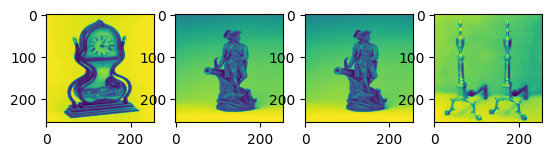

In [138]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols = 4)

images_for_vect = [images[i] for i in [0, 1, 1, 20]]

for i in range(len(images_for_vect)):
    axes[i].imshow(images_for_vect[i][0])

plt.show()

In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.nn.functional import cosine_similarity

class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pulling = nn.AdaptiveAvgPool2d(4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.linear = nn.Linear(512, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pulling(x)
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = self.linear(x)
        return x

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):

        cosine_distance = cosine_similarity(output1, output2)

        loss_contrastive = torch.mean((1 - target) * torch.pow(cosine_distance, 2) +
                                      (target) * torch.pow(torch.clamp(self.margin - cosine_distance, min=0.0), 2))
        return loss_contrastive

In [8]:
import torch.optim as optim

encoder = ImageEncoder().to(device)
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(encoder.parameters(), lr=0.05)

In [18]:
from tqdm.notebook import tqdm
import math

losses = []
num_epochs = 5
for epoch in range(num_epochs):
    encoder.train()
    running_loss = 0.0
    shard_count = 0

    # Определяем количество шардов для текущей эпохи

    for _ in tqdm(range(math.floor(dataloader.dataset.n_shards * 0.5)), desc=f'Epoch {epoch+1}', leave=False):
        batch = next(iter(dataloader))
        inputs, labels = batch

        # Переносим батч на устройство
        images = (inputs.to(device) if isinstance(inputs, torch.Tensor) else [torch.tensor(inp).to(device) for inp in inputs])
        images = torch.stack(images) if isinstance(images, list) else images.unsqueeze(0)

        # Разделяем батч на две части
        images1, images2 = torch.split(images, 2, dim=0)

        optimizer.zero_grad()

        # Пропускаем обе части батча через энкодер
        outputs1 = encoder(images1)
        outputs2 = encoder(images2)

        # Определяем таргет на основе меток (labels)
        target = torch.tensor(labels[0] == labels[1], dtype=torch.float).to(device)
        # Вычисляем потерю между выходами
        loss = criterion(outputs1, outputs2, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        shard_count += 1

    # Выводим среднюю потерю для каждой эпохи
    average_loss = running_loss / shard_count
    print(f"Эпоха {epoch+1}, Loss: {average_loss}")
    losses.append(average_loss)


Epoch 1:   0%|          | 0/24 [00:00<?, ?it/s]

Эпоха 1, Loss: 0.3251739210584977


Epoch 2:   0%|          | 0/24 [00:00<?, ?it/s]

Эпоха 2, Loss: 0.0008981086126974939


Epoch 3:   0%|          | 0/24 [00:00<?, ?it/s]

Эпоха 3, Loss: 5.643691784863273e-05


Epoch 4:   0%|          | 0/24 [00:00<?, ?it/s]

Эпоха 4, Loss: 4.457106108191056e-06


Epoch 5:   0%|          | 0/24 [00:00<?, ?it/s]

Эпоха 5, Loss: 3.531077752231641e-07


In [24]:
from sklearn.metrics import f1_score, accuracy_score
import random

encoder.eval()

train_loader = DataLoader(museum_staff, batch_size=32, collate_fn=transformed_collate_fn)
images, _ = next(iter(train_loader))

image1 = images[random.randint(0, 32)]
image2 = images[random.randint(0, 32)]

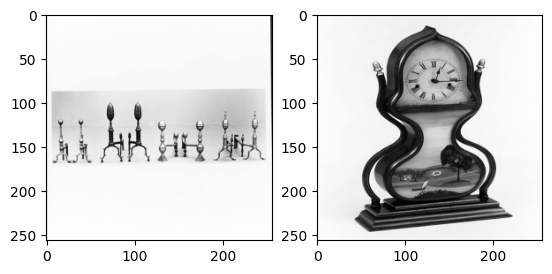

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2)

axes[0].imshow(image1[0], cmap='gray')
axes[1].imshow(image2[0], cmap='gray')

In [37]:
image1_tensor = torch.from_numpy(image1).unsqueeze(0)
image2_tensor = torch.from_numpy(image2).unsqueeze(0)

output1 = encoder(image1_tensor)
output2 = encoder(image2_tensor)

In [41]:
from torch.nn.functional import cosine_similarity

cosine_similarity(output1, output2)

tensor([0.9942], grad_fn=<SumBackward1>)

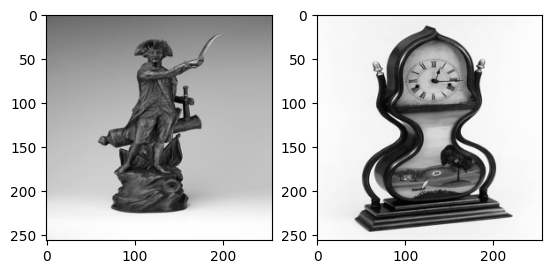

tensor([0.0003], grad_fn=<SumBackward1>)


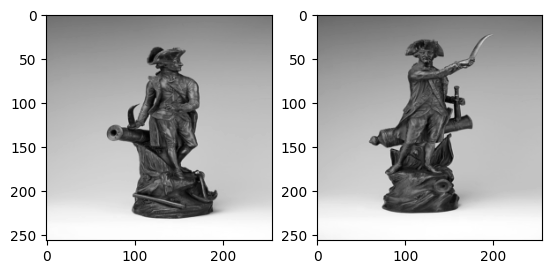

tensor([0.9965], grad_fn=<SumBackward1>)


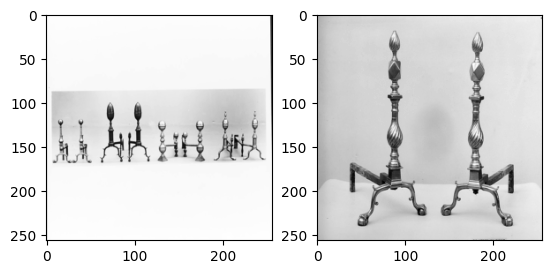

tensor([0.9954], grad_fn=<SumBackward1>)


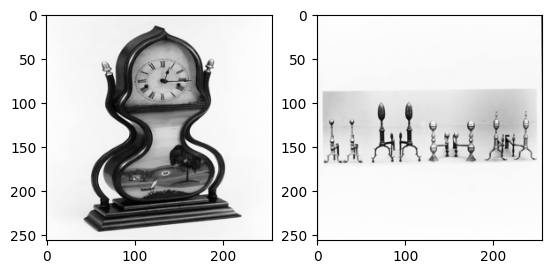

tensor([0.9942], grad_fn=<SumBackward1>)


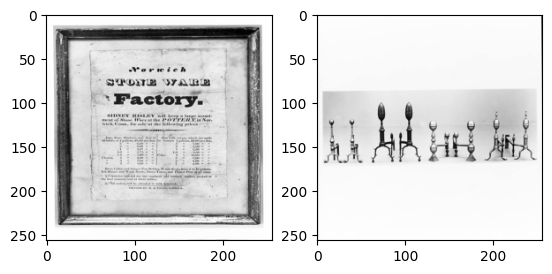

tensor([0.9982], grad_fn=<SumBackward1>)


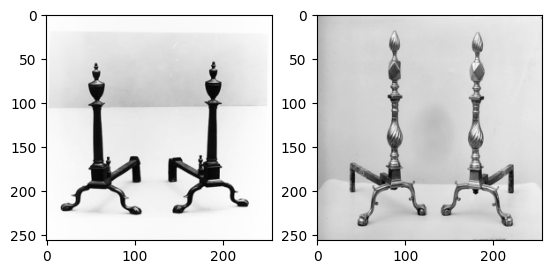

tensor([0.9924], grad_fn=<SumBackward1>)


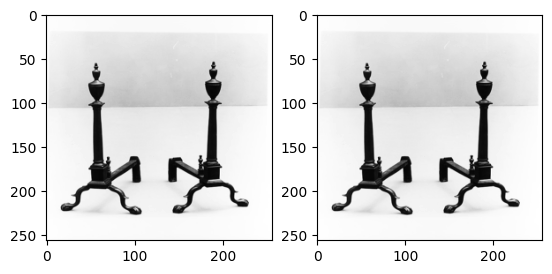

tensor([1.0000], grad_fn=<SumBackward1>)


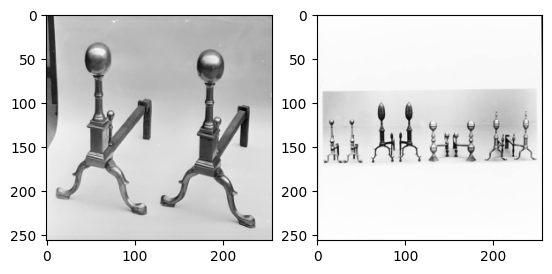

tensor([0.9840], grad_fn=<SumBackward1>)


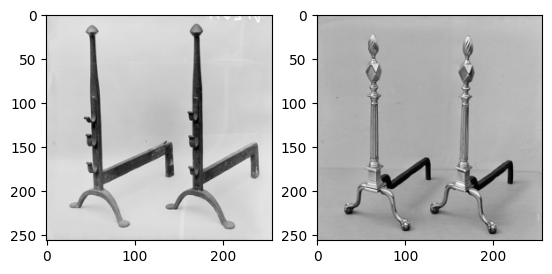

tensor([0.9500], grad_fn=<SumBackward1>)


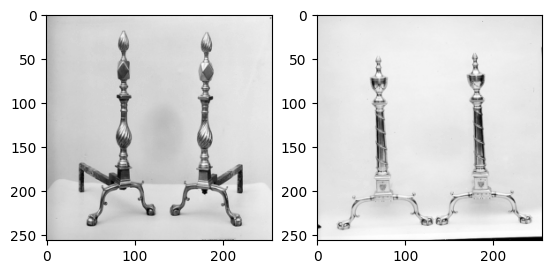

tensor([0.9995], grad_fn=<SumBackward1>)


In [43]:
from sklearn.metrics import f1_score, accuracy_score
import random
from torch.nn.functional import cosine_similarity

def check_my_model():
  encoder.eval()

  train_loader = DataLoader(museum_staff, batch_size=32, collate_fn=transformed_collate_fn)
  images, _ = next(iter(train_loader))

  image1 = images[random.randint(0, 32)]
  image2 = images[random.randint(0, 32)]

  fig, axes = plt.subplots(ncols=2)

  axes[0].imshow(image1[0], cmap='gray')
  axes[1].imshow(image2[0], cmap='gray')

  plt.show()

  image1_tensor = torch.from_numpy(image1).unsqueeze(0)
  image2_tensor = torch.from_numpy(image2).unsqueeze(0)

  output1 = encoder(image1_tensor)
  output2 = encoder(image2_tensor)

  print(cosine_similarity(output1, output2))
  return

for i in range(10):
    check_my_model()

In [1]:
torch.save(encoder.state_dict(), 'encoder.pth')

NameError: name 'torch' is not defined

In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.nn.functional import cosine_similarity

class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pulling = nn.AdaptiveAvgPool2d(4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.linear = nn.Linear(512, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pulling(x)
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = self.linear(x)
        return x

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):

        cosine_distance = cosine_similarity(output1, output2)

        loss_contrastive = torch.mean((1 - target) * torch.pow(cosine_distance, 2) +
                                      (target) * torch.pow(torch.clamp(self.margin - cosine_distance, min=0.0), 2))
        return loss_contrastive

In [4]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import functools
import numpy as np

class SqueezeAndToNumpy:
    def __call__(self, tensor):
        if tensor.dim() == 3:
            squeezed_tensor = tensor.permute(1, 2, 0)[:, :, 0].unsqueeze(0)
        else:
            squeezed_tensor = tensor
        return squeezed_tensor

def transform_data(samples, transformer):
    images = [sample['image'] for sample in samples]
    object_names = [sample['object_name'] for sample in samples]
    transformed_images = [transformer(image) for image in images]
    return np.array(transformed_images), object_names

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((256, 256)),
    transforms.ConvertImageDtype(torch.float),
    SqueezeAndToNumpy()
])



transformed_collate_fn = functools.partial(transform_data, transformer=transform)


In [6]:
import pandas as pd
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset

encoder = ImageEncoder()

encoder_state_dict = torch.load('../models/encoder.pth')

encoder.load_state_dict(encoder_state_dict)

encoder.eval()


museum_staff = load_dataset("miccull/met_museum", streaming=True, split="train")

train_loader = DataLoader(museum_staff, batch_size=256, collate_fn=transformed_collate_fn)
images, _ = next(iter(train_loader))

In [10]:

from PIL import Image
image_list = []
images_num = []
num = 0
for image in (images):
  image_tensor = torch.from_numpy(image).unsqueeze(0)
  output = encoder(image_tensor)

  image_list.append(output.detach())
  images_num.append(num)
  num += 1

In [39]:
df

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,similarity,image_id
0,"[[tensor(-1911.4135), tensor(-72.8145), tensor...","[[tensor(523.5802), tensor(-1471.8602), tensor...","[[tensor(785.0648), tensor(-1655.6534), tensor...","[[tensor(-2531.4939), tensor(66.7377), tensor(...","[[tensor(-1418.5936), tensor(-247.6505), tenso...","[[tensor(-1942.8563), tensor(495.5638), tensor...","[[tensor(-2990.2947), tensor(229.2131), tensor...","[[tensor(-2990.2947), tensor(229.2131), tensor...","[[tensor(-2604.9670), tensor(-129.4188), tenso...","[[tensor(-2604.9670), tensor(-129.4188), tenso...",...,"[[tensor(2406.4436), tensor(-2470.0879), tenso...","[[tensor(-2875.2346), tensor(102.2360), tensor...","[[tensor(-962.5869), tensor(2.5141), tensor(-1...","[[tensor(-887.9325), tensor(152.5788), tensor(...","[[tensor(-1098.3683), tensor(-555.5577), tenso...","[[tensor(35.0690), tensor(-654.1238), tensor(5...","[[tensor(42.6976), tensor(-1806.4120), tensor(...","[[tensor(-1918.2804), tensor(-478.6253), tenso...",NaN,0


In [11]:
# Соединяем тензоры в один
concatenated_tensor = torch.cat(image_list, dim=0)

# Удаляем размерность с единичным элементом
concatenated_tensor = concatenated_tensor.squeeze()

# Преобразуем тензор в массив NumPy
numpy_array = concatenated_tensor.numpy()

# Создаем DataFrame
df = pd.DataFrame(numpy_array)

df['similarity'] = np.nan
df['image_id'] = range(len(df))

In [17]:
import numpy as np
#np.cov(images[0])
new_img = images[0]
image_tensor = torch.from_numpy(new_img).unsqueeze(0)
output = encoder(image_tensor).detach().numpy()
np.cov(output)

array(1775800.92470512)

1775800.9247051156
1733718.5377436867


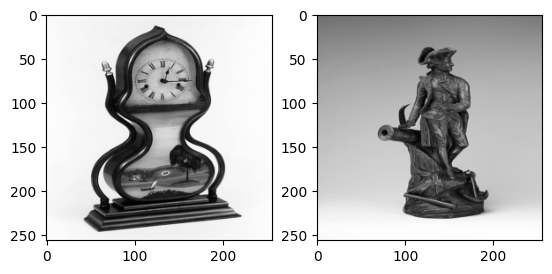

In [24]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(images[0][0], cmap='gray')
axes[1].imshow(images[1][0], cmap='gray')

image_tensor = torch.from_numpy(images[1]).unsqueeze(0)
output1 = encoder(image_tensor).detach().numpy()

print(np.cov(output))
print(np.cov(output1))


2538149.7415869385


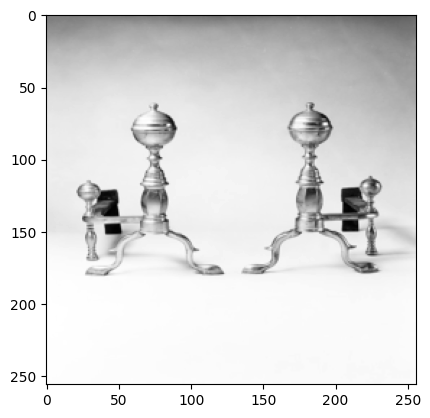

In [26]:
image_tensor = torch.from_numpy(images[55]).unsqueeze(0)
output2 = encoder(image_tensor).detach().numpy()

print(np.cov(output2))
plt.imshow(images[55][0], cmap='gray')

In [44]:
df

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,similarity,image_id
0,-1911.413452,-72.814529,-1863.292725,-1749.896118,-1910.623413,1947.193481,-1888.060791,-1038.359009,487.237152,679.714844,...,521.468384,1736.070068,1308.087769,625.332581,993.731201,759.796875,779.546997,-1237.187256,NaN,0
1,523.580200,-1471.860229,477.161011,-2416.140625,-420.371277,-567.316833,820.175842,-145.208603,2268.940186,1667.178345,...,-1203.004639,2594.205322,1975.350342,-823.229187,1298.736816,-1133.640503,2302.132324,693.551147,NaN,1
2,785.064819,-1655.653442,807.797729,-2611.298340,-340.532349,-852.839661,1057.114014,-137.184860,2533.568604,1841.247070,...,-1383.803955,2795.951172,2163.462158,-1059.519775,1323.552124,-1365.943726,2547.076904,859.771240,NaN,2
3,-2531.493896,66.737717,-2964.989502,-1924.612427,-2365.387695,2862.063477,-2440.549561,-1457.136230,505.249115,680.053955,...,841.705444,2219.269531,1527.784790,1244.236328,1200.432251,841.155396,758.117310,-1494.645020,NaN,3
4,-1418.593628,-247.650467,-1609.594360,-1596.237549,-1518.904175,1574.766113,-1336.308594,-880.704102,702.543579,733.243896,...,266.197754,1728.759399,1260.059937,521.392151,960.495300,334.546783,871.552002,-772.219482,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-887.932495,152.578781,-1230.293457,-527.858459,-833.715454,1110.701904,-819.959534,-536.197510,109.399696,83.191765,...,373.511597,798.285828,450.885071,674.755310,398.784180,243.589798,152.710709,-596.427429,NaN,123
124,-1098.368286,-555.557678,-1216.341797,-1907.750366,-1407.397217,1183.637451,-948.984680,-757.442932,1105.496094,1006.442017,...,-59.000965,2022.036255,1504.647705,241.047821,1142.796143,64.419449,1272.572388,-484.776978,NaN,124
125,35.068958,-654.123779,5.205938,-1232.928589,-422.317169,-23.592319,133.953308,-222.934464,1048.086914,812.161072,...,-443.480652,1294.397705,1005.135254,-342.283417,660.583740,-444.309723,1066.561890,157.547134,NaN,125
126,42.697620,-1806.411987,168.556641,-3414.507568,-1098.105347,-114.597198,313.804382,-657.319885,2822.541260,2235.513916,...,-1267.924927,3609.979736,2857.774658,-959.202454,1828.754150,-1048.797241,2970.251465,498.061401,NaN,126


Текущее изображение:
Наиболее похожие изображения:


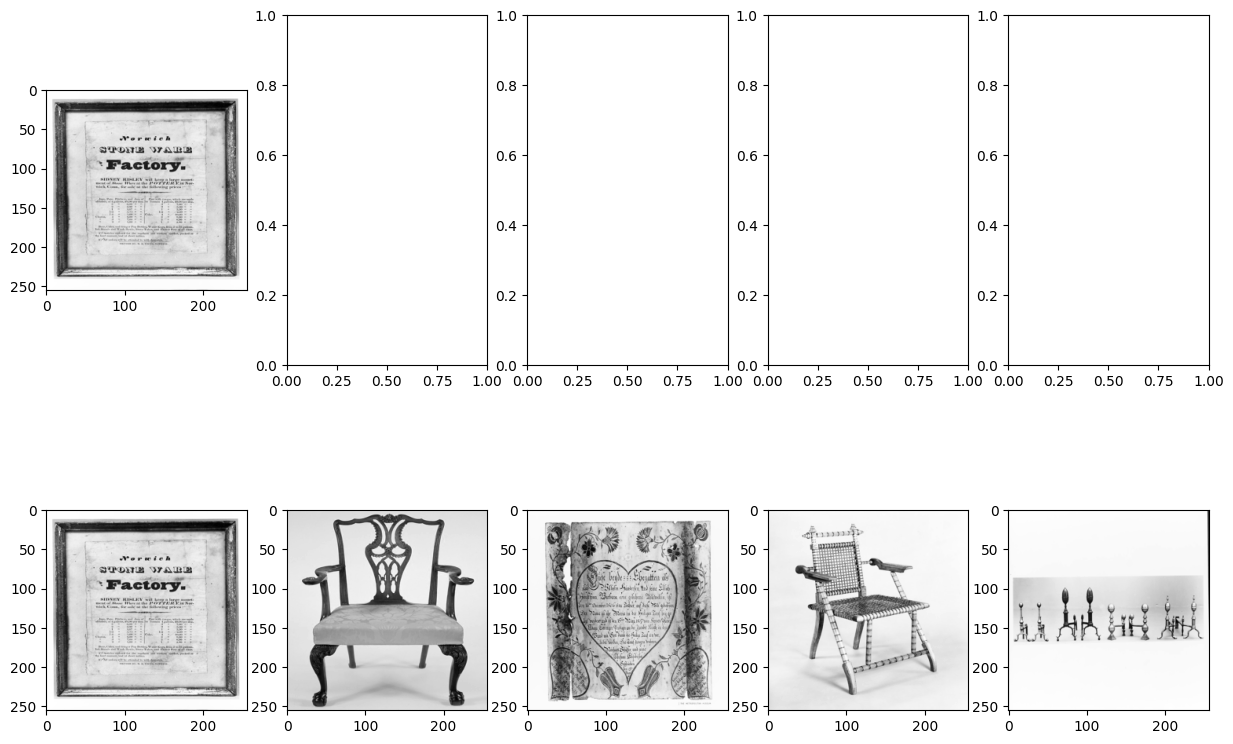

In [62]:
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt


def calculate_similarity(row):
    # Преобразуем вектор строки в тензор PyTorch
    row_tensor = torch.tensor(row[:128], dtype=torch.float32)
    # Вычисляем косинусное сходство между векторами
    similarity = F.cosine_similarity(row_tensor, new_vector_tensor, dim=0)
    return similarity.item()

new_images, _ = next(iter(train_loader))
new_image1 = new_images[random.randint(0, 128)]

image_tensor = torch.from_numpy(new_image1).unsqueeze(0)
output = encoder(image_tensor)

# Преобразуем выходной тензор в тензор PyTorch
new_vector_tensor = output.squeeze(0)

# Создаем новый столбец с сходством
df['similarity'] = df.apply(calculate_similarity, axis=1)

# Сортируем датафрейм по столбцу с сходством
df_sorted = df.sort_values(by='similarity', ascending=False)

# Выводим текущее изображение
fig, axes = plt.subplots(ncols = 5, nrows= 2, figsize=(15, 10))
print("Текущее изображение:")
axes[0][0].imshow(new_image1[0], cmap='gray')

# Выводим первые 5 похожих изображений
print("Наиболее похожие изображения:")
for i in range(5):
    axes[1][i].imshow(images[int(df_sorted.iloc[i]['image_id'])][0], cmap='gray')
